In [34]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error


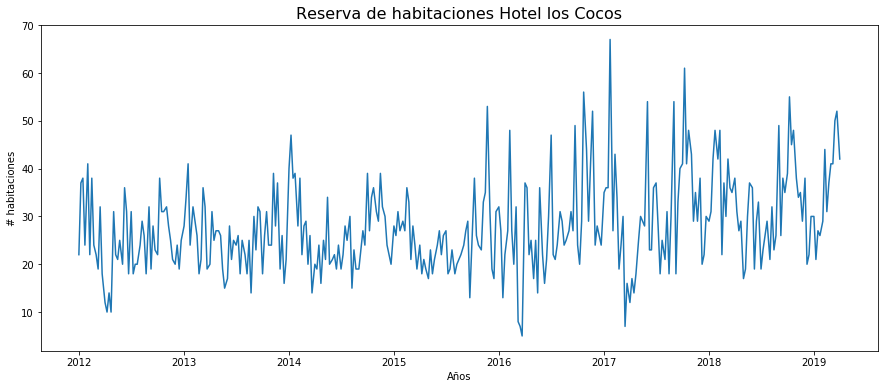

In [35]:

#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
ts = data['#guests']

#imprimir la serie de tiempo y guardarla en la carpeta imagen como referencia
plt.plot(data, linewidth=1.5)
plt.title('Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel('# habitaciones')
plt.xlabel('Años')
plt.show()

In [36]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349 entries, 2012-01-01 to 2019-04-01
Data columns (total 1 columns):
#guests    349 non-null int64
dtypes: int64(1)
memory usage: 5.5 KB
None


In [37]:
#determinacion tipo de modelo (estacionario o no estacionario)

def test_stacionary(timeseries):
    
    #Estadisticas de la determinacion del balanceo (Media Movil y Desviacion Estandar)
    rolmean = timeseries.rolling(window=4).mean()
    rolSTD = timeseries.rolling(window=4).std()
    
    #Graficar estadisticas de balanceo
    orig = plt.plot(timeseries, label='Original', linewidth=1.5, color='orange');
    mean = plt.plot(rolmean, label='Media Movil', linewidth=1.5,color='green');
    std = plt.plot(rolSTD, label='Desviacion Estandar', linewidth=1.5,color='black');
    plt.title("Rolling Mean and Standard Deviation");
    plt.legend(loc='best');
    plt.tight_layout();
    plt.ylabel('Habitaciones')
    plt.xlabel('Años')
    plt.show(block = False)
    
    #perform dickfuller
    print('Resultados de prueba de Augmented Dickey-Fuller:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadistico de prueba', 'p-value', '# de retrasos', '# de observaciones'])
    for key, value in dftest[4].items():
        dfoutput['Valor critico ({})'.format(key)] = value
    print(dfoutput)
    

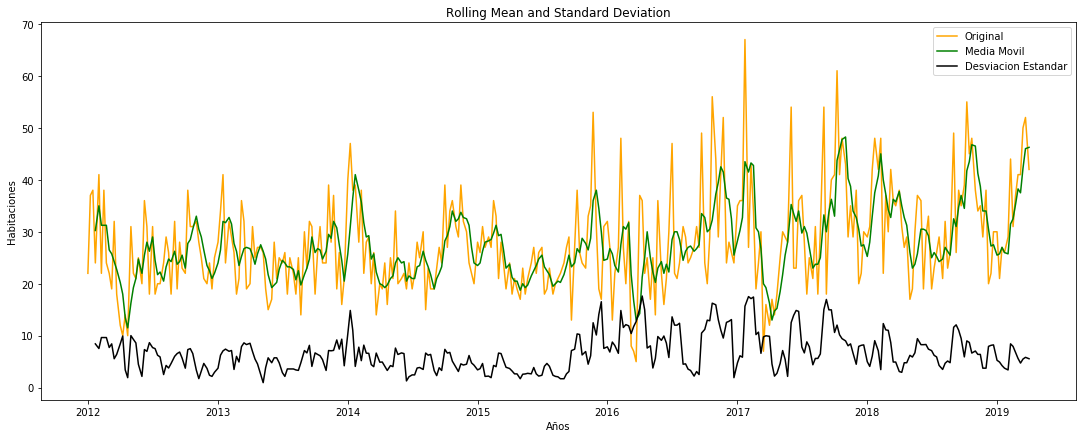

Resultados de prueba de Augmented Dickey-Fuller:
Estadistico de prueba    -6.68622
p-value                   0.00000
# de retrasos             2.00000
# de observaciones      346.00000
Valor critico (1%)       -3.44939
Valor critico (5%)       -2.86993
Valor critico (10%)      -2.57124
dtype: float64


In [38]:
test_stacionary(ts)

Text(0.5, 0, 'Años')

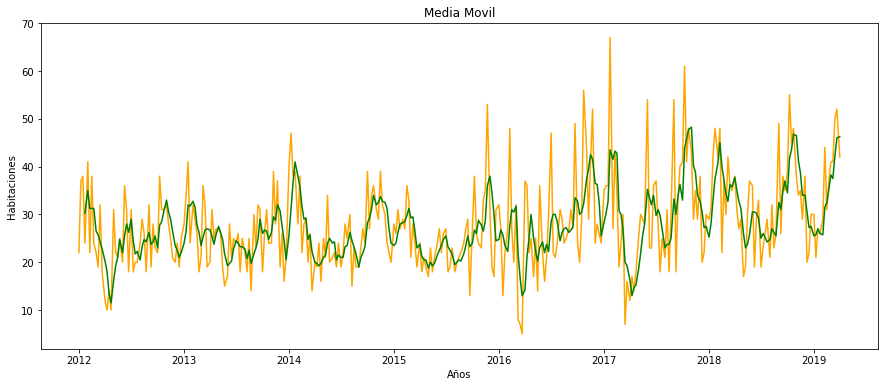

In [39]:
#Calculo de la media movil
moving_average = ts.rolling(4).mean()
plt.plot(ts, color='orange')
plt.plot(moving_average, color='green') 
plt.title('Media Movil')
plt.ylabel('Habitaciones')
plt.xlabel('Años')

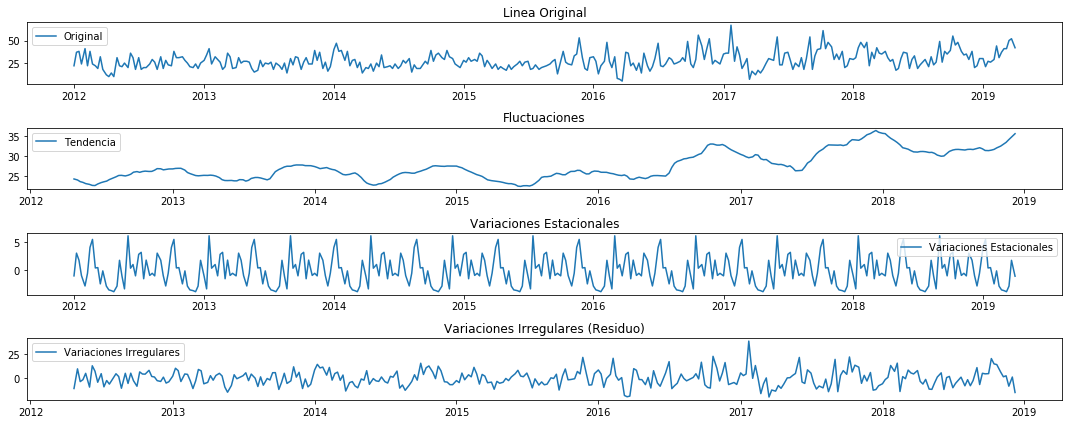

In [40]:
#descomposicion de los componentes de la serie

descomposicion = sm.tsa.seasonal_decompose(ts, freq=30)

trend = descomposicion.trend
seasonal = descomposicion.seasonal
residual = descomposicion.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best');
plt.title('Linea Original')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best');
plt.title('Fluctuaciones')
plt.subplot(413)
plt.plot(seasonal, label='Variaciones Estacionales')
plt.legend(loc='best');
plt.title('Variaciones Estacionales')
plt.subplot(414)
plt.plot(residual, label='Variaciones Irregulares')
plt.legend(loc='best');
plt.title('Variaciones Irregulares (Residuo)')
plt.tight_layout();

In [41]:
#prediccion SARIMA
# Dividir data en entrenamiento y prueba
y = data['#guests']
y_train = y[:'2018']
y_test = y['2019':]
print('Prueba ', len(y_test))
print(y_test)
print(' ')
print('Entrenamiento ', len(y_train))
print(y_train)

Prueba  13
time
2019-01-01    30
2019-01-08    21
2019-01-15    27
2019-01-22    26
2019-02-01    29
2019-02-08    44
2019-02-15    31
2019-02-22    37
2019-03-01    41
2019-03-08    41
2019-03-15    50
2019-03-22    52
2019-04-01    42
Name: #guests, dtype: int64
 
Entrenamiento  336
time
2012-01-01    22
2012-01-08    37
2012-01-15    38
2012-01-22    24
2012-02-01    41
2012-02-08    22
2012-02-15    38
2012-02-22    24
              ..
2018-11-01    38
2018-11-08    34
2018-11-15    35
2018-11-22    29
2018-12-01    38
2018-12-08    20
2018-12-15    22
2018-12-22    30
Name: #guests, Length: 336, dtype: int64


In [42]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

#calculo de la mejor sarimax
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error: ", sys.exc_info()[0])
            continue
print("Best SARIMAX {} x {} 12 model - AIC: {}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX (1, 0, 1) x (0, 1, 1, 12) 12 model - AIC: 2339.940016449836


In [47]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7548      0.091      8.319      0.000       0.577       0.933
ma.L1         -0.4441      0.122     -3.627      0.000      -0.684      -0.204
ma.S.L12      -0.8565      0.033    -26.031      0.000      -0.921      -0.792
sigma2        75.5193      4.692     16.096      0.000      66.323      84.715


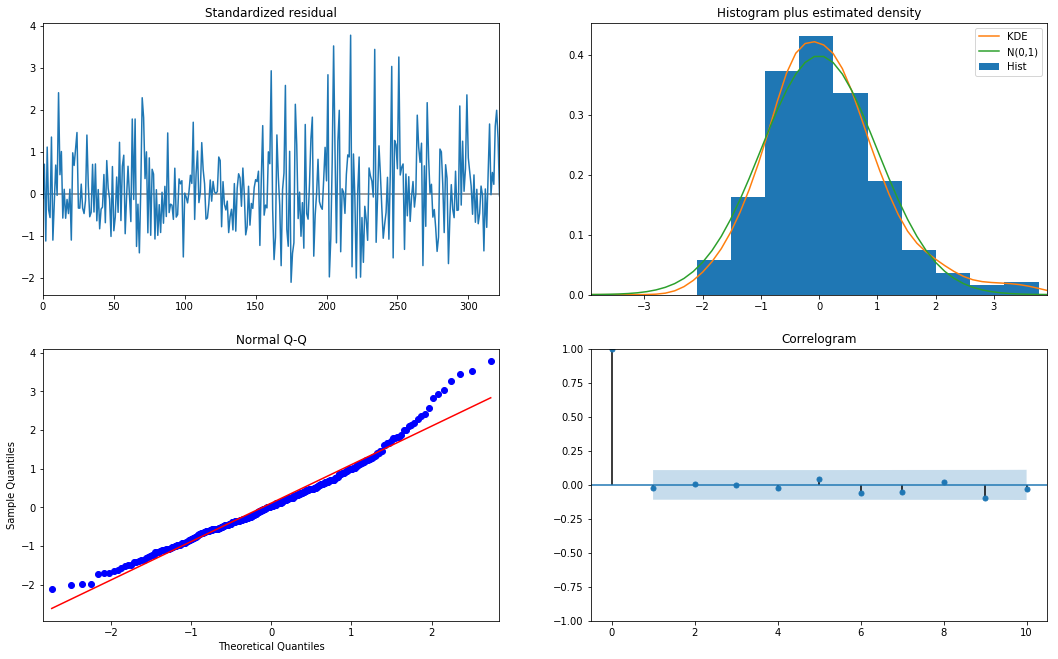

In [48]:
results.plot_diagnostics(figsize=(18, 11))
plt.show()

In [51]:
# Entranamiento del modelo
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

#Prediccion data prueba
pred = res.get_prediction(start=337, 
                          end=380,
                          dynamic=False)

#Muestra de resultados
prediction = list(map(lambda x: int(x), pred.predicted_mean))
print(y_test)
print('Prediccion:')
print(prediction)


time
2019-01-01    30
2019-01-08    21
2019-01-15    27
2019-01-22    26
2019-02-01    29
2019-02-08    44
2019-02-15    31
2019-02-22    37
2019-03-01    41
2019-03-08    41
2019-03-15    50
2019-03-22    52
2019-04-01    42
Name: #guests, dtype: int64
Prediccion:
[32, 29, 35, 28, 31, 28, 30, 36, 24, 26, 30, 31, 33, 30, 35, 29, 31, 28, 30, 36, 24, 26, 30, 31, 33, 30, 35, 29, 31, 28, 30, 36, 24, 26, 30, 31, 33, 30, 35, 29, 31, 28, 30, 36]


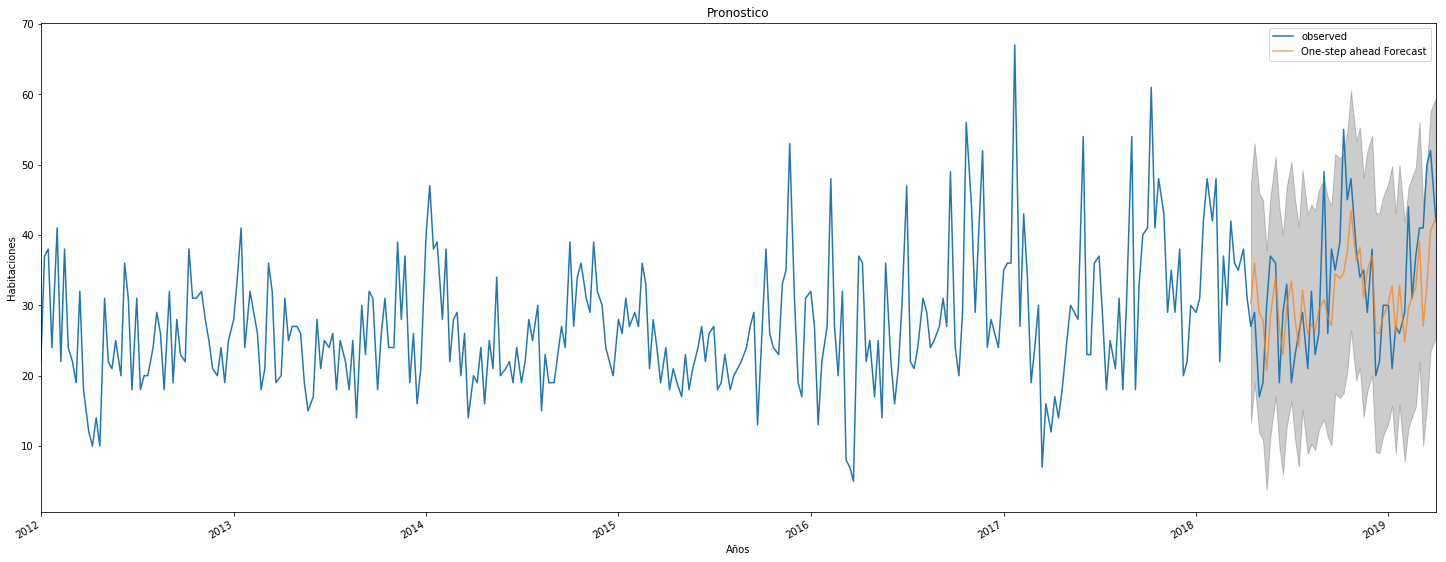

In [53]:
#Plot the forecasted values with historical data
pred = results.get_prediction(start=302, dynamic=False)

pred_ci = pred.conf_int()

ax = y['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(25, 10))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Años')
ax.set_ylabel('Habitaciones')
plt.legend()
plt.title('Pronostico')
plt.show()

In [13]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

In [16]:
#Calculo del MSE
rms = sqrt(mean_squared_error(y_test, prediction))
print('MSE',rms)
real=np.array(y_test)
print(real)
predi=np.array(prediction)
print(predi)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MSE 13.991755814379793
[30 21 27 26 29 44 31 37 41 41 50 52 42]
[35 31 34 25 28 25 23 38 18 25 27 27 40]
